## Import Libraries & Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

##  Set all Constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 70
n_classes = 16

##  Importating data into tenserflow dataset object

To load every picture in the tensorflow dataset, we will utilize the image dataset from directory api:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "Plants",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 13286 files belonging to 16 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Corn_Blight',
 'Corn_Common_Rust',
 'Corn_Gray_Leaf_Spot',
 'Corn_Healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Rice_Bacterial_leaf_blight',
 'Rice_Brown spot',
 'Rice_Healthy',
 'Rice_Leaf_smut',
 'Rice_septoria',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

## Visualizeing the images from dataset

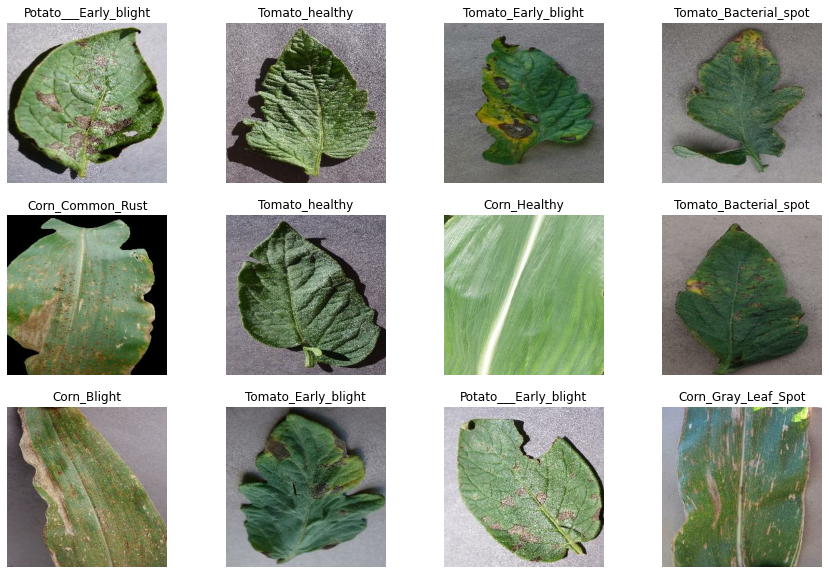

In [42]:
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

### Function to Split Dataset

The dataset should be divided into these 3 subsets:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model

In [6]:
len(dataset)

416

In [ ]:
80% => training
20% => 10% validation, 10% test

In [7]:
train_size = 0.8
len(dataset)*train_size

332.8

In [8]:
train_ds = dataset.take(332)
len(train_ds)

332

In [9]:
test_ds = dataset.skip(332)
len(test_ds)

84

In [10]:
val_size = 0.1
len(dataset)*val_size

41.6

In [11]:
val_ds = test_ds.take(41)
len(val_ds)

41

In [12]:
test_ds = test_ds.skip(41)
len(test_ds)

43

In [13]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(dataset)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [15]:
len(train_ds)

332

In [16]:
len(val_ds)

41

In [17]:
len(test_ds)

43

### Cache, Shuffle, and Prefetch the Dataset

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Creating a Layer for Resizing and Normalization

We should resize our images to the correct size before sending them over the network. Additionally, normalizing the picture pixel value will help the model perform better (keeping them in range 0 and 1 by dividing by 256). Both inference and this should take place during training. In light of this, we may include that as a layer in our sequential model.

You might be wondering why we need to resize the image to (256,256). You are correct that we don't need to, however this would be helpful after the model training is complete and predictions are being made using it. At that point, anyone may give a non-(256,256) picture, and this layer will resize it.

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
When we have less data, we need to augment it; by doing so, our model's accuracy is increased.

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (128, 256, 256, 3)        0         
                                                                 
 conv2d_6 (Conv2D)           (128, 254, 254, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPooling  (128, 127, 127, 32)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (128, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (128, 62, 62, 64)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (128, 60, 60, 64)        

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    x=train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/70
332/332 [==============================] - 760s 2s/step - loss: 1.6405 - accuracy: 0.4590 - val_loss: 1.0026 - val_accuracy: 0.6677
Epoch 2/70
332/332 [==============================] - 436s 1s/step - loss: 0.8640 - accuracy: 0.7082 - val_loss: 0.7659 - val_accuracy: 0.7378
Epoch 3/70
332/332 [==============================] - 432s 1s/step - loss: 0.6486 - accuracy: 0.7757 - val_loss: 0.8162 - val_accuracy: 0.7142
Epoch 4/70
332/332 [==============================] - 431s 1s/step - loss: 0.5571 - accuracy: 0.8014 - val_loss: 0.5789 - val_accuracy: 0.7927
Epoch 5/70
332/332 [==============================] - 435s 1s/step - loss: 0.4883 - accuracy: 0.8240 - val_loss: 0.4747 - val_accuracy: 0.8239
Epoch 6/70
332/332 [==============================] - 436s 1s/step - loss: 0.4469 - accuracy: 0.8374 - val_loss: 0.5891 - val_accuracy: 0.7965
Epoch 7/70
332/332 [==============================] - 426s 1s/step - loss: 0.4099 - accuracy: 0.8497 - val_loss: 0.6619 - val_accuracy: 0.7698

Epoch 58/70
332/332 [==============================] - 456s 1s/step - loss: 0.0960 - accuracy: 0.9667 - val_loss: 0.1121 - val_accuracy: 0.9550
Epoch 59/70
332/332 [==============================] - 435s 1s/step - loss: 0.1053 - accuracy: 0.9607 - val_loss: 0.0892 - val_accuracy: 0.9748
Epoch 60/70
332/332 [==============================] - 427s 1s/step - loss: 0.0975 - accuracy: 0.9628 - val_loss: 0.1896 - val_accuracy: 0.9398
Epoch 61/70
332/332 [==============================] - 428s 1s/step - loss: 0.1222 - accuracy: 0.9578 - val_loss: 0.1876 - val_accuracy: 0.9367
Epoch 62/70
332/332 [==============================] - 430s 1s/step - loss: 0.0960 - accuracy: 0.9653 - val_loss: 0.1115 - val_accuracy: 0.9619
Epoch 63/70
332/332 [==============================] - 428s 1s/step - loss: 0.0871 - accuracy: 0.9674 - val_loss: 0.1346 - val_accuracy: 0.9550
Epoch 64/70
332/332 [==============================] - 429s 1s/step - loss: 0.0981 - accuracy: 0.9660 - val_loss: 0.1404 - val_accuracy:

In [25]:
scores = model.evaluate(test_ds)

43/43 [==============================] - 169s 376ms/step - loss: 0.1038 - accuracy: 0.9630


In [26]:
scores

[0.10384345054626465, 0.9629629850387573]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 332}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
len(history.history['accuracy'])

70

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

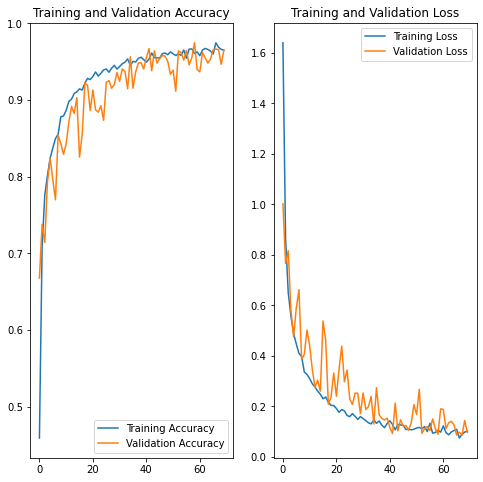

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [283]:
np.argmax([9.09711750e-21, 9.99887943e-01, 1.12074544e-04, 5.75578539e-13])

1

First Image to Predict
Actual label: Tomato_Bacterial_spot
1/1 [==============================] - 0s 413ms/step
Predicted Label: Tomato_Bacterial_spot


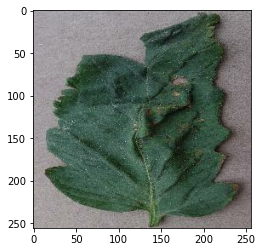

In [41]:
for image_batch, label_batch in test_ds.take(1):
    
#     print(image_batch[0].numpy().astype('uint8'))
#     plt.imshow(image_batch[0].numpy().astype('uint8'))
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First Image to Predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


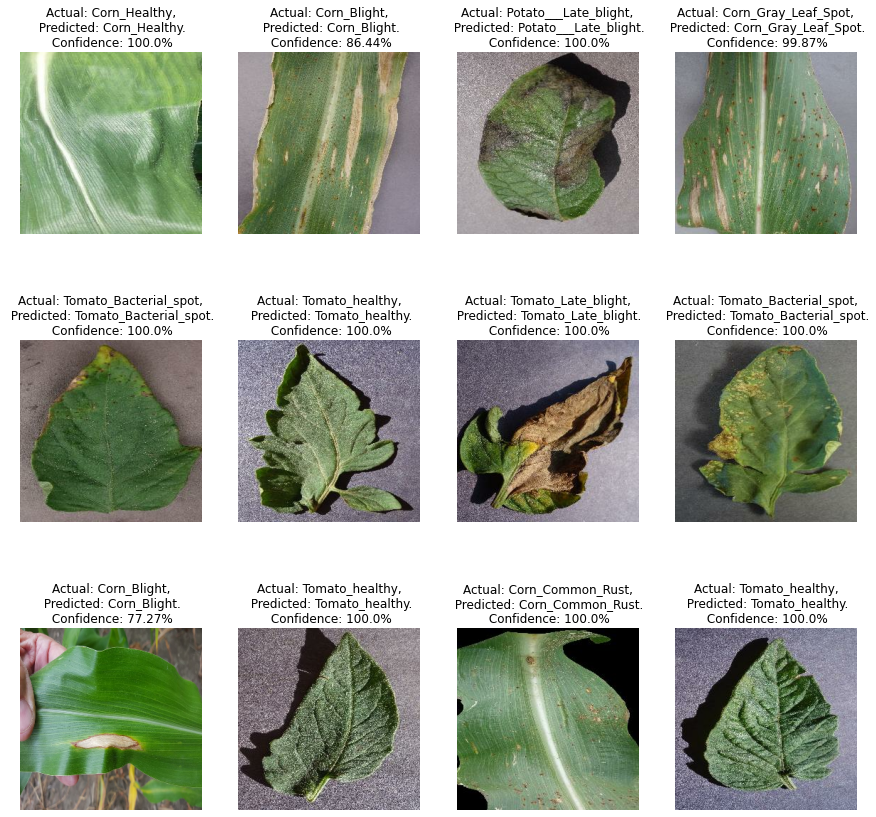

In [57]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Exporting / Saving the mode

In [55]:
import os

# To Ignore Erros
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Auto Append to the list of model as a new version
model_version=max([int(i) for i in os.listdir('../models') + [0]]) + 1

# For saving as normal file
model.save(filepath=f"../models/{model_version}")

# For saving as h5
# model.save(filepath=f"../models/{model_version}", save_format="h5")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
